# Sparkify Churn: Capstone Project 
### by Abdishakur Yoonis

![caption](files/images/Sparkify.png)

## Table of Contents
* [Introduction](#int)
* [Load and Clean Dataset](#load)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#eng)
* [Modelling](#model)
* [Conclusions](#con)

## Introduction
<a class="anchor" id="int"></a>

In this project I will load and manipulate a music app dataset similar to Spotify with Spark to engineer relevant features for predicting churn. Where Churn is cancelling their service altogether. By identifying these customers before they churn, the business can offer discounts and incentives to stay thereby potentially saving the business revenue. This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

First let's import the necessary libraries.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We can now create a Spark Session.

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'YOONIS'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '20163'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1650402062669'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

## Load and Clean Dataset
<a class="anchor" id="load"></a>
Our mini-dataset file is `mini_sparkify_event_data.json`. First the dataset must be loaded and cleaned, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# load in the dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [8]:
# get the count of the dataset before we do any cleaning - this is 286500
df.count()

286500

The dataset before any cleaning is performed has 286500 rows.

### Drop Rows with Missing Values

First we will drop any rows with missing values in the userid or sessionid.

In [9]:
# drop rows with missing values in userid and/or sessionid
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [10]:
df.count()

286500

As we can see from the above, the row count is still the same at 286500. Let's take a closer look.

In [12]:
# drop userid duplicates
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



From the above, we can see that there are empty strings being used for a userId. We will drop these after we further investigate the sessionid.

In [13]:
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



The sessionId looks as expected. However we saw from above that there are entries with an empty string for the userId. These should now be removed. 

In [14]:
# remove those with an empty string userId
df = df.filter(df["userId"] != "")

In [15]:
df.count()

278154

We have dropped (286500-278154) = **8346 rows** in this cleaning step.

In [16]:
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


## Exploratory Data Analysis
<a class="anchor" id="eda"></a>

### Define Churn

A column `Churn` will be created to use as the label for our model. `Cancellation Confirmation` events is used to define churn, which happen for both paid and free users. We will assign a 1 where a user has churned and a 0 where they have not churned.

### Explore Data
Exploratory data analysis will  be performed to observe the behavior for users who stayed vs users who churned. Starting by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Identify users who have churned

First, we will identify the users who have churned using the `Cancellation Confirmation` event under the `page` column.

In [17]:
# check Cancellation Confirmation page
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



From the above we can see that Cancellation Confirmation is the page that a user is taken to once they have confirmed that they would like to cancel their service. Again, this is how we are identifying churn.

In [18]:
# number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

We will now create the flag for churned users who will be assigned a 1 if churned and a 0 where they have not churned. This flag will be added to the dataset as a column named "churn".

In [20]:
# flag the records where Cancellation Confirmation page is reached - 1 if it is and 0 if not
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [21]:
#creating churn column
df = df.withColumn("churn", churn_event("page"))

In [22]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

From the above example we can see that the churn column has been successfully added to the dataframe and a 0 has been assigned for this particular userId. Now we can sort our records for a userId in reverse time order and add up the values in the churn column.

In [23]:
# sort records for a user in reverse time order so we can add up vals in churn column
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [24]:
# create column churn which contains sum of churn 1s over records
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [25]:
# groupby churn to get counts
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [26]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### EDA for Users that Stayed vs Users that Churned

Now we can examine behaviour of those who churned vs those who did not churn. First we will visualise those who churned vs those who stayed.

In [27]:
# convert to pandas for visualisation
df_churn = df_churn.toPandas()

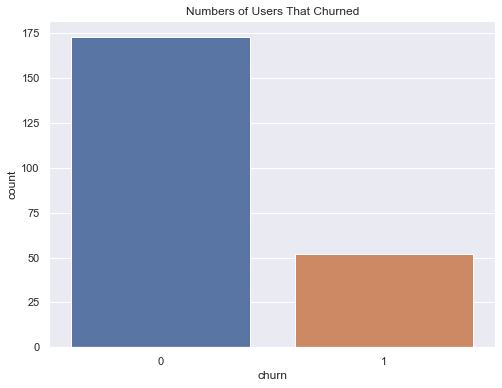

In [28]:
# plot the number of users that churned
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Numbers of Users That Churned");

In [29]:
# calculate churn rate
52/(173+52) * 100

23.11111111111111

From the above, we can see that 173 users stayed while 52 users churned. Therefore this means that 23% of our users churned. It is important to note moving forward that this is an imbalance.

### Length of time: Users that Churned vs. Users that Stayed

We can now look at the length distribution for customers who stayed and those which churned. 

In [30]:
# get those customers who churned
df_len = df.filter(df.churn ==1)

In [31]:
# convert to pandas
df_pd = df_len.toPandas()

In [32]:
# drop the nulls
df_pd.length.dropna(inplace=True)

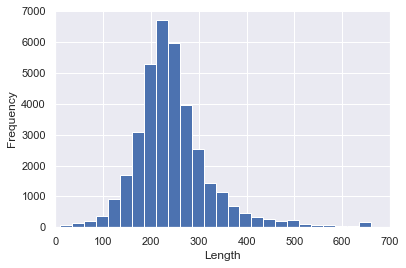

In [33]:
# plot the distribution
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

Now we can do the same process for customers who didn't churn.

In [34]:
# users who stayed
df_len_stay = df.filter(df.churn ==0)

In [35]:
# convert to pandas
df_pd = df_len_stay.toPandas()

In [36]:
# drop nulls
df_pd.length.dropna(inplace=True)

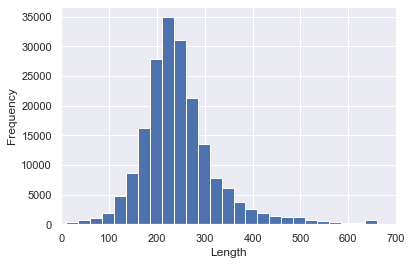

In [37]:
# plot distribution
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

We can see from the above plots that length distribution is very similar for users that churned and those who stayed. This won't be very useful for predicting customer churn. Let's try a categorical feature: gender.

###  Gender - Users who Churned vs Users who Stayed

Now we can examine if gender had an effect on users that churned vs. those that stayed.

In [38]:
# create gender df grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [39]:
# show gender df 
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [40]:
# convert to pandas for visualisation
df_gender = df_gender.toPandas()

In [41]:
# order for the visualisation
df_gender = df_gender.sort_values('count', ascending = False)

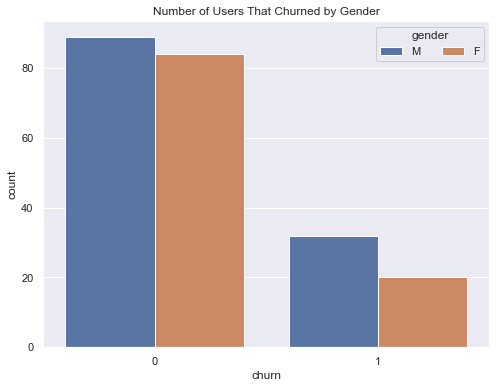

In [42]:
# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned by Gender");

In [43]:
# male churn rate
32/(89+32)

0.2644628099173554

In [44]:
# female churn rate
20/(20+84)

0.19230769230769232

From the above chart, we can see that more male users churned(rate of 0.264) compared to female users (rate of 0.192).

### Users who Churned vs Stayed by Level

Next we can examine if level has an effect on whether a user will churn or not. By level here we mean if the user paid for the app or if they used it for free with ads.

In [45]:
# create the level dataframe
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [46]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [47]:
# convert to pandas for visualisation
df_level = df_level.toPandas()

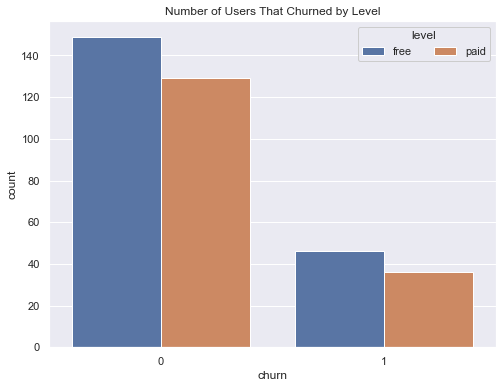

In [48]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users That Churned by Level");

In [49]:
# free churn rate
46/(46+149)

0.2358974358974359

In [50]:
# paid churn rate
36/(129+36)

0.21818181818181817

We can see from the above chart that more users who used the service for free were slightly more likely to churn (rate of 0.236) compared to those who paid for the app (0.218).

### Pages Visited by Those that Churned vs. Those That Stayed

Next we can examine if there were different pages visited by users that churned compared to those that remained.

In [51]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [52]:
df_page.show(40)

+--------------------+-----+------+
|                page|churn| count|
+--------------------+-----+------+
|            Settings|    0|  1244|
|         Thumbs Down|    1|   496|
|           Thumbs Up|    1|  1859|
|     Add to Playlist|    1|  1038|
|               Error|    1|    32|
|               About|    1|    56|
|         Thumbs Down|    0|  2050|
|         Roll Advert|    1|   967|
|                Home|    0|  8410|
|Cancellation Conf...|    1|    52|
|               Error|    0|   220|
|              Cancel|    1|    52|
|            Settings|    1|   270|
|          Add Friend|    1|   636|
|             Upgrade|    0|   387|
|           Downgrade|    1|   337|
|              Logout|    1|   553|
|    Submit Downgrade|    1|     9|
|       Save Settings|    0|   252|
|           Thumbs Up|    0| 10692|
|           Downgrade|    0|  1718|
|      Submit Upgrade|    0|   127|
|         Roll Advert|    0|  2966|
|    Submit Downgrade|    0|    54|
|              Logout|    0|

In [53]:
# convert to pandas
df_page = df_page.toPandas()

In [54]:
# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

Now that we have a count of the number of customers who churned and those that stayed we can calculate the rate and create this as a column on our dataFrame.

In [55]:
# calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 

In [56]:
df_page.head(40)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


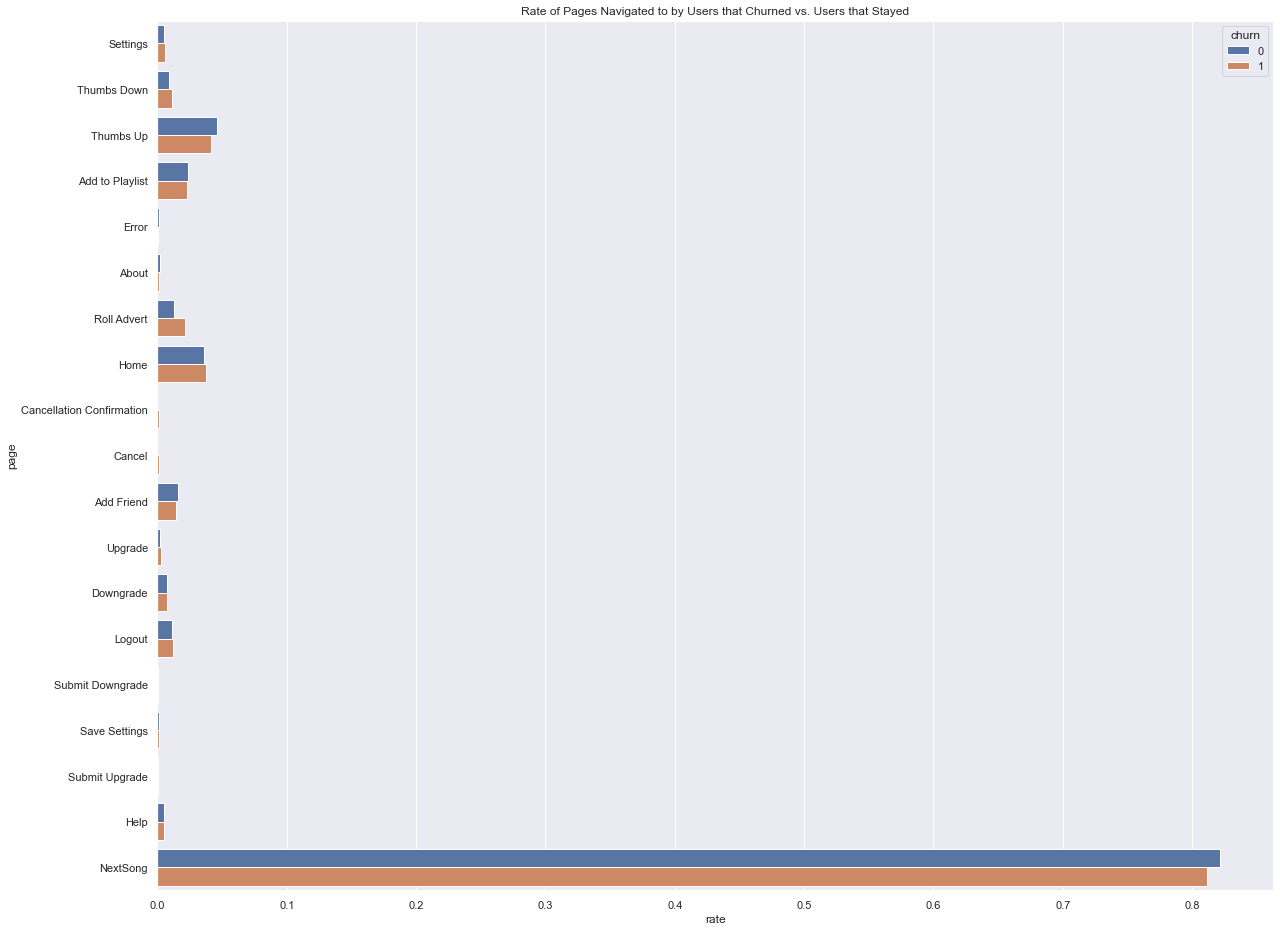

In [57]:
# plot the pages by churn
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed');

From the above chart, we can see that the most popular action for both users that stayed and those that churned was to skip to the next song. We can also see that churned users rolled the ad and thumbs down songs more. Those who were more likely to stay performed more thumbs up actions, added friends and also added songs to playlist.

### Calculating Songs per Hour

We can now turn our attention to calculating the number of songs listened to by churn and non churn users per hour. 

In [58]:
# get hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [59]:
# create hour column
df = df.withColumn("hour", get_hour(df.ts))

In [60]:
df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18')

First we can look at those who didn't churn.

In [61]:
# create a df with those who didnt churn and which counts when user goes to next song page
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [62]:
songs_in_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 7763|
|   1| 7337|
|   2| 7000|
|   3| 7009|
|   4| 6934|
|   5| 6779|
|   6| 6906|
|   7| 6905|
|   8| 7003|
|   9| 7098|
|  10| 7308|
|  11| 7300|
|  12| 7877|
|  13| 8043|
|  14| 8508|
|  15| 9223|
|  16| 9529|
|  17| 9682|
|  18| 9327|
|  19| 8984|
|  20| 9106|
|  21| 9135|
|  22| 8655|
|  23| 8303|
+----+-----+



In [63]:
# convert to pandas and then to numeric
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)

In [64]:
songs_in_hour_stay_pd

,hour,count
0,0,7763
1,1,7337
2,2,7000
3,3,7009
4,4,6934
5,5,6779
6,6,6906
7,7,6905
8,8,7003
9,9,7098


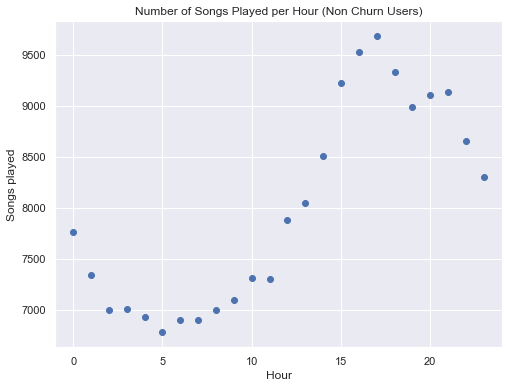

In [65]:
# plot the distribution
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour (Non Churn Users)");

From above we can see that there is a peak of songs played between 3pm and 8pm. Next we will examine users who churned by using the same process.

In [66]:
# dataframe with customers who churned and count next song page 
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [67]:
songs_in_hour_churned.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1564|
|   1| 1558|
|   2| 1339|
|   3| 1350|
|   4| 1295|
|   5| 1200|
|   6| 1208|
|   7| 1214|
|   8| 1222|
|   9| 1261|
|  10| 1294|
|  11| 1353|
|  12| 1348|
|  13| 1436|
|  14| 1539|
|  15| 1813|
|  16| 1852|
|  17| 1886|
|  18| 2019|
|  19| 1956|
+----+-----+
only showing top 20 rows



In [68]:
# convert to pandas and to numeric
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)

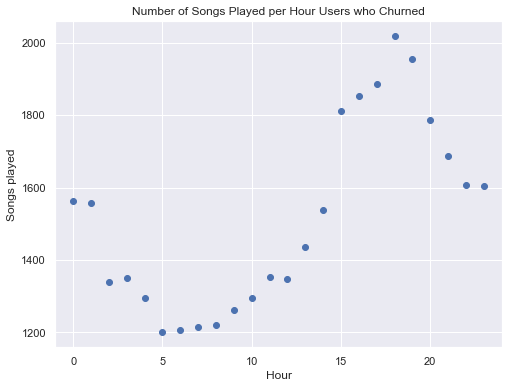

In [69]:
# plot distribution of songs per hour for churned
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");

We can see users that churned had a similar distribution, however they listened to fewer songs per hour than users that stayed.

### Songs Per Session for Users who Churned vs. Those who Stayed

We can plot this in a simple way which will allow us to compare those who churned and those who stayed in a bar chart by getting the averages for both groups.

In [71]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [73]:
# get average grouped by churn
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [74]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

In [75]:
# convert this to pandas df
df_songs = df_songs.toPandas()

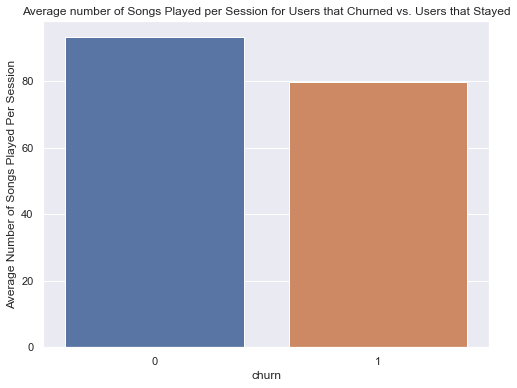

In [76]:
# plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_songs, x = 'churn', y='avg(count)')
plt.title("Average number of Songs Played per Session for Users that Churned vs. Users that Stayed")
plt.ylabel("Average Number of Songs Played Per Session");

From the chart we can see that those churned from Sparkify actually listening to fewer songs on average per session.

### Number of Unique Artists Listened to

We can create a similar chart for the number of artists that users listened to.

In [78]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [79]:
# get averages
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [80]:
# convert to pandas
df_artists = df_artists.toPandas()

We can plot this as a boxplot to see the max and medians for both groups. 

In [ ]:
# plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = df_artists, x = 'churn', y='count')
plt.title("Number of Artists Listened to on Sparkify");

From the above we can see that those who didn't churn listened to a larger number of different artists compared to those who churned.

### Location

We can now examine if location had an effect on churn.

In [81]:
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



Let's just extract the state from the location by taking the last two characters in the location string.

In [82]:
# get last two characters
get_state = udf(lambda x: x[-2:])

In [83]:
# create state column
df_state = df.withColumn("state", get_state(df.location))

In [84]:
# check that create state column worked
df_state.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18', state='CT'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18', stat

In [85]:
df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

In [86]:
# convert to pandas 
df_state_pd = df_state.toPandas()

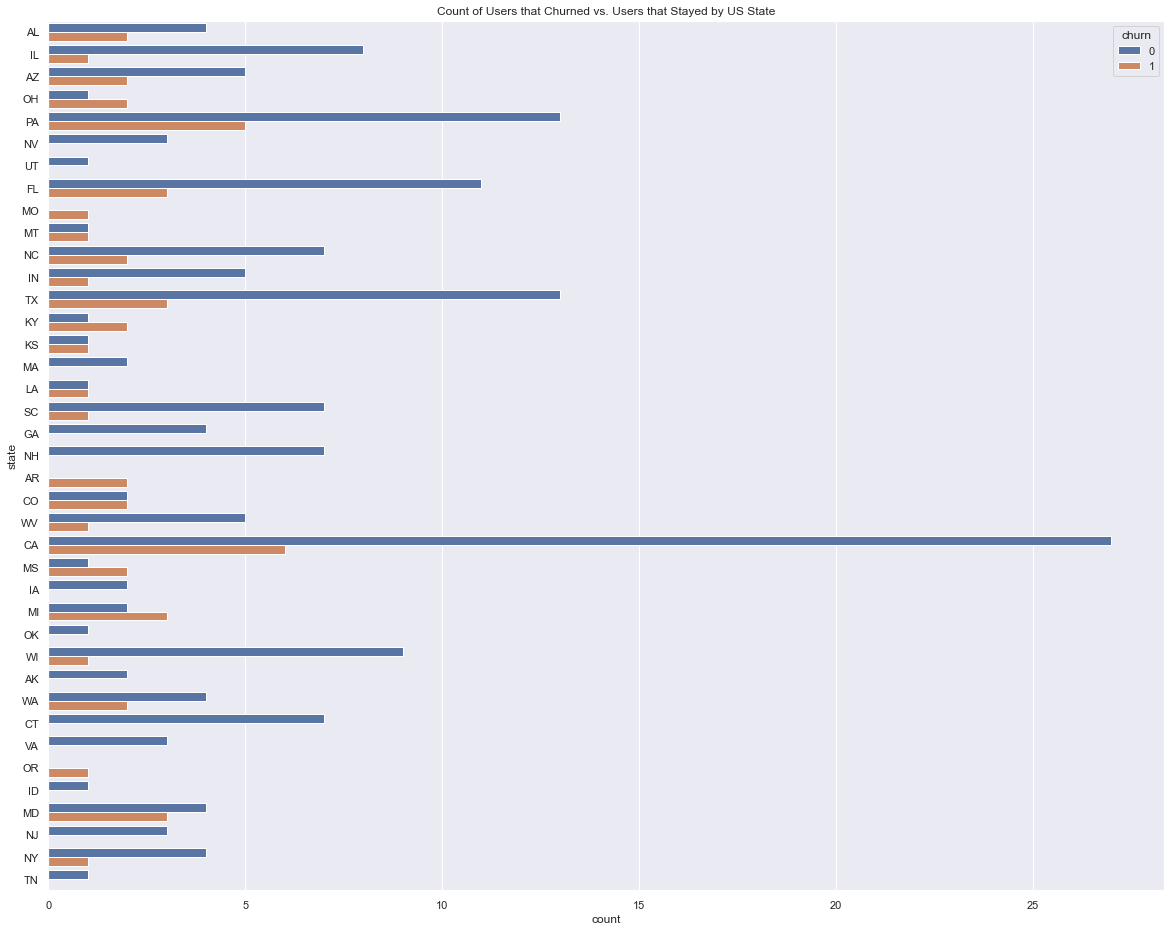

In [87]:
# plot 
plt.figure(figsize=[20,16])
sns.barplot(data = df_state_pd, x = 'count', y = 'state', hue = 'churn')
plt.title('Count of Users that Churned vs. Users that Stayed by US State');

Most users were based in CA. More users in MI, KY, and OH states churned than stayed. This may be difficult to engineer a useful feature for when it comes to modelling. Let's leave this for now and move onto another column from our dataset; operating systems and browsers.

### UserAgent: Operating System and Browsers

Now we can extract the Operating System a user is on to understand if this has an effect on churn.

In [88]:
df_opsys = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])

In [89]:
df_opsys.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|100010|"Mozilla/5.0 (iPh...|    0|
|200002|"Mozilla/5.0 (iPh...|    0|
|   125|"Mozilla/5.0 (Mac...|    1|
|   124|"Mozilla/5.0 (Mac...|    0|
|    51|"Mozilla/5.0 (Win...|    1|
|     7|Mozilla/5.0 (Wind...|    0|
|    15|"Mozilla/5.0 (Win...|    0|
|    54|Mozilla/5.0 (Wind...|    1|
|   155|"Mozilla/5.0 (Win...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|   132|"Mozilla/5.0 (Mac...|    0|
|   154|"Mozilla/5.0 (Win...|    0|
|   101|Mozilla/5.0 (Wind...|    1|
|    11|Mozilla/5.0 (Wind...|    0|
|   138|"Mozilla/5.0 (iPa...|    0|
|300017|"Mozilla/5.0 (Mac...|    0|
|100021|"Mozilla/5.0 (Mac...|    1|
|    29|"Mozilla/5.0 (Mac...|    1|
|    69|"Mozilla/5.0 (Win...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [90]:
# convert to pandas
df_opsys = df_opsys.toPandas()

In [91]:
# get the possible list of operating systems
df_opsys.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        12
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                10
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"     

In [92]:
# create list of operating systems
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

In [93]:
# create os column and extract strings that match our os_list and add to column 
df_opsys['os'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [94]:
# check that worked
df_opsys

,userId,userAgent,churn,os
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0,iPhone
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0,iPhone
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows
...,...,...,...,...
220,45,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",0,Windows
221,57,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac
222,200021,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,1,Mac
223,119,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",0,Windows


In [95]:
df_opsys.os.value_counts()

Windows    111
Mac         86
iPhone      13
Linux       12
iPad         3
Name: os, dtype: int64

In [96]:
# order for the plot
os_order = df_opsys.os.value_counts().index

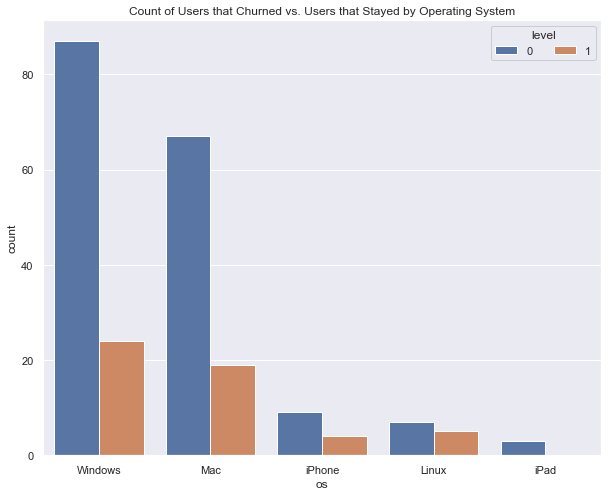

In [97]:
# plot count for churn and non churn users
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'os', hue ='churn', order = os_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Operating System')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Windows was the most used. Linux users have the highest rate of churn. It is very few customers that this has affected therefore this won't be used in our model.

We can also look if browsers had an effect on churn using the same process.

In [98]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

In [99]:
df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

In [100]:
df_opsys.browser.value_counts()

Chrome     117
Firefox     50
Safari      46
Trident     12
Name: browser, dtype: int64

Here Trident is Internet Explorer software. Let's change Trident to 'Internet Explorer' as it is better known.

In [103]:
df_opsys['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)

In [104]:
# order for the plot
browser_order = df_opsys.browser.value_counts().index

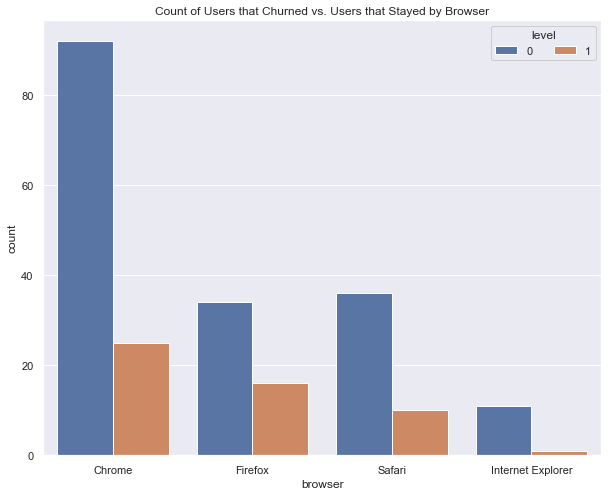

In [105]:
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'browser', hue ='churn', order = browser_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Chrome was the most popular browser. Firefox users were most likely to churn. Internet Explorer had the fewest number of users that churned. There is no clear issue with browsers which is making users churn. Therefore this won't be used in our model.

### Days Since Registration for Sparkify

Finally, we can look at the number of days since a user had registered.

In [106]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [107]:
# order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [108]:
# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [109]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [110]:
# just get those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [111]:
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

Now need to minus these and work that out in days.

In [112]:
# need to minus the registration from ts 
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [113]:
df_days.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [114]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [115]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [116]:
# to Pandas for the plot
df_days_pd = df_days.toPandas()

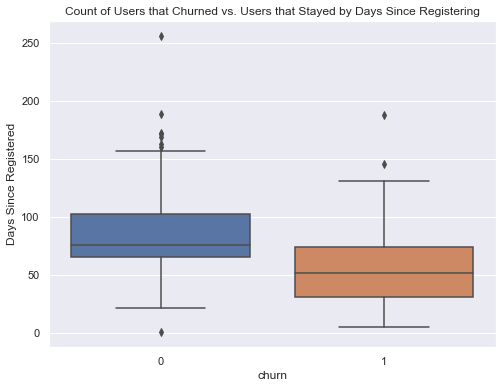

In [117]:
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered");

On average those who had been registered with Sparkify for longer were more likely to stay. Users who had registered more recently were more likely to churn.

# Feature Engineering
<a class="anchor" id="eng"></a>

Now that EDA has been performed, we can build out the features that seem most promising to train our model on.

The features we will build out are:
- Categorical:
 - gender
 - level

- Numerical:
 - number of songs per session
 - number of rollads actions
 - number of thumb down actions
 - number of thumbs up actions
 - number of friends added
 - number of songs added to playlist
 - number of different artists listened to on Sparkify
 - number of days since registering
 
We will also then add a churn label and join these all together. This will create a dataFrame where each row represents information pertaining to each individual user. Once we drop the userId, this dataframe can be vectorised, standarised and fed into our different machine learning algorithms.

First we will take our categorical variables and convert these into numeric variables, ready for our model.

### Gender

Our first feature is gender which is a categorical one. We will assign a 1 for 'female' and a 0 for 'male'.

In [118]:
gender_f1 = df.select(['userId', 'gender']).dropDuplicates()

In [119]:
# create gender column 
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [120]:
gender_f1.count()

225

In [121]:
# check
gender_f1.show(20)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



### Level

The next feature we will take is level. The level can change so we need to only take the most recent. We can use the rank trick from before.

In [122]:
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [123]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [124]:
df2 = df2.withColumn("Rank", dense_rank().over(w))

In [125]:
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [126]:
level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)

In [127]:
level_f2 = level_f2.drop('ts')

In [128]:
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [129]:
level_f2.count()

225

In [130]:
level_f2.show(20)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



### Average Number of songs per session

Our third feature is average number of songs per session for each user.

In [131]:
song_f3 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

In [132]:
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [133]:
song_f3 = song_f3.groupby('userId').agg({"count":"avg"})

In [134]:
song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")

In [135]:
song_f3.count()

225

In [136]:
song_f3.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



### Number of rollads actions

Next feature we can consider is number of roll advert actions. This had a higher number of roll ad count for those who churned since those who use the app for free are shown ads whereas paid subscribers aren't shown ads.

In [137]:
rollad_f4 = df.select(["userId", "page"])

In [138]:
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [139]:
# creating rollad column
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))

In [140]:
rollad_f4 = rollad_f4.groupby('userId').sum("rollad")

In [141]:
rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

In [142]:
rollad_f4.count()

225

In [143]:
rollad_f4.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
+------+-------+
only showing top 2 rows



### Number of thumb down actions

The fifth feature we can add to our feature dataframe is thumbs down. Users who had churned in the past had performed more thumbs down actions than those who stayed with the service. 

In [144]:
thumbdown_f5 = df.select(["userId", "page"])

In [145]:
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [146]:
thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))

In [147]:
thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")

In [148]:
thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [149]:
thumbdown_f5.count()

225

In [150]:
thumbdown_f5.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
+------+-----------+
only showing top 2 rows



### Number of thumbs up actions


We can do the same for thumb up actions. Users who stayed with the service had performed more thumbs up actions in the past.

In [151]:
thumbup_f6 = df.select(["userId", "page"])

In [152]:
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [153]:
thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))

In [154]:
thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")

In [155]:
thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [156]:
thumbup_f6.count()

225

In [157]:
thumbup_f6.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
+------+---------+
only showing top 2 rows



### Number of friends added

Similarly, number of friends added can indicate if a user is likely to churn or not. In the past, those who added more friends stayed with the app.

In [158]:
friend_f7 = df.select(["userId", "page"])

In [159]:
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [160]:
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))

In [161]:
friend_f7 = friend_f7.groupby('userId').sum("add_friend")

In [162]:
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")

In [163]:
friend_f7.count()

225

In [164]:
friend_f7.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
+------+----------+
only showing top 2 rows



### Number of songs added to playlist

Again, those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [165]:
playlist_f8 = df.select(["userId", "page"])

In [166]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [167]:
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))

In [168]:
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")

In [169]:
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")

In [170]:
playlist_f8.count()

225

In [171]:
playlist_f8.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
+------+--------+
only showing top 2 rows



### Number of different Artists Listened to on Sparkify

As we discovered in EDA, users that listened to more diverse artists were less likely to churn.

In [172]:
artists_f9 = df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [173]:
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")

In [174]:
artists_f9.count()

225

In [175]:
artists_f9.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



### Number of Days Since Registering

Number of days since registering also looked useful from our EDA. We saw that users who had a shorter number of days since registering churned more than those who had used the service for a longer time.

In [176]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [177]:
days_f10 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

In [178]:
days_f10.count()

225

In [179]:
days_f10.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



### Label

Now we can create our label column indicating if the user churned (1) or not (0).

In [180]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [181]:
label = label.drop('count')

In [182]:
label.count()

225

In [183]:
label = label.withColumnRenamed("churn", "label")

In [184]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



### Create Features Dataset

Now that we have our features we need to join these together on `userId`.

In [185]:
feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])

In [186]:
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|100010|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|   124|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|       2233|131.55591435185184|    0|
|    51|     0|    1|             211.1|      0|         21|      100|        28|      52|       1386|19

Now we can drop the userId.

In [187]:
feature_df = feature_df.drop('userId')

In [188]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|       2233|131.55591435185184|    0|
|     0|    1|             211.1|      0|         21|      100|        28|      52|       1386|19.455844907407407|    1|
|     0|    0|21.428571428571427

Now we have a dataframe with all the features we can into our model where each row represents a user.However first we need to do some preprocessing.

## Preprocessing

In [189]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



Now we need to take these columns and convert into the numerical datatypes that will be used in our model: integers and floats. We can use write a function to adhere to DRY principles.

In [190]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [191]:
# check this works
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



The next stage of preprocessing is to vectorise our features.

### Vector Assembler

The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [192]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")

In [193]:
feature_df = assembler.transform(feature_df)

In [194]:
feature_df.show()

+------+-----+---------+-------+-----------+---------+----------+--------+-----------+----------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|      days|label|        vec_features|
+------+-----+---------+-------+-----------+---------+----------+--------+-----------+----------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|       4.0|     7.0|      253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|       4.0|     8.0|      340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0|  71.31689|  1.0|(10,[2,3,8,9],[8....|
|   1.0|  1.0|145.67857|    4.0|       41.0|    171.0|      74.0|   118.0|     2233.0| 131.55591|  0.0|[1.0,1.0,145.6785...|
|   0.0|  1.0|    211.1|    0.0|       21.0|    100.0|      28.0|    52.0|     1386.0| 19.455845|  1.0|[0.0,1.0,211.1000...|


### Standardisation

Now that we have our vectors we can standardise our values. This is important for our machine learning model so that those features with the highest values don't dominate the results and so that we can make the individual features look like standard normally distributed data.

In [195]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [196]:
scaler_model = scaler.fit(feature_df)

In [197]:
feature_df = scaler_model.transform(feature_df)

In [198]:
feature_df.head(2)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_down=5.0, thumbs_up=17.0, add_friend=4.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 2.413, 0.3823, 0.2596, 0.1943, 0.214, 0.4189, 1.4775])),
 Row(gender=0.0, level=1.0, avg_song=64.5, roll_ad=7.0, thumbs_down=6.0, thumbs_up=21.0, add_friend=4.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]))]

We can see from above that standardisation has worked by comparing  vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), to features=DenseVector([0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]). 

## Train / Test / Validation Split

Let's check how many records we have in total is 225 as it should be.

In [199]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



This count is what we would expect, now we can split our data into train, test and validation sets. Here we will do a 60:20:20 split and include a seed so we can reproduce the result. I've included the same seed for the different machine learning models so that my results can be reproduced.

In [200]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:132
Test Dataset:53
Validation Dataset:40


# Modelling
<a class="anchor" id="model"></a>

Now we have created our features dataFrame with only numeric variables, we can split the full dataset into train, test, and validation sets. We will test out different machine learning classification algorithms including:
 - Logistic Regression
 - Random Forest Classifier
 - Gradient-Boosted Tree Classifier
 - Linear Support Vector Machine
 - Naive Bayes
 
We will use these classification algorithms since churn prediction is a binary classification problem, meaning that customers will either churn (1) or they will stay (0) in a certain period of time. 

### Metrics
We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I will use F1 score as the metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here.

Now we can start modelling. When we identify the model with the best F1 score, accuracy and time we will then tune the model.


The models I have selected are below with the reasons why these have been chosen. Each model that has been chosen is suitable for our binary classification problem of predicting churn.

- **Logistic Regression:** Logistic regression is the first machine learning algorithm we can try. Logistic regression is a reliable machine learning algorithm to try since this is a binary classification problem and logistic regression provides a model with good explainability. Logistic regression is also easy to implement, interpret and is efficient to train. It is also less inclined to overfitting.       
- **Random Forest:** Random Forest is a powerful supervised learning algorithm that can be used for classification. RF is an ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached. This can help avoid overfitting. RF is also robust and has good performance on imbalanced datasets like we have here.        
- **Gradient Boosted Tree Classifier:** GBT provides good predictive accuracy. This works by building one tree at a time where each new tree helps correct errors made by the previous tree compared to RF which builds trees independently. There is a risk of overfitting with GBT so this needs to be considered. However GBT performs well with unbalanced data which we have here.    
- **Linear SVC:** SVC is another supervised learning binary classification algorithm. It works well with clear margins of separations between classes and is memory efficient.    
- **Naive Bayes:** Finally, we will try Naive Bayes. This is another classifier algorithm that is easy to implement and is fast.

### Training the Models & Evaluating the Model Performance
Steps:
 - Instantiate 
 - Fit Models on Train
 - Predicting
 - Evaluating


In [201]:
# instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=1996)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1996)
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [202]:
#list of models
model_list = [lr,rf,gbt,lsvc,nb]

In [203]:
# evaluator we are using is multiclassclassificationevaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [204]:
# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 279.5488770008087 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.7411764705882353
The accuracy of the LogisticRegression model is: 0.775
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 368.33607029914856 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.6645161290322582
The accuracy of the RandomForestClassifier model is: 0.7
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 313.2293817996979 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassifier is: 0.754616048317515
The accuracy of the GBTClassifier model is: 0.775
LinearSVC training started
LinearSVC training ended
Time taken for Linear

Now that we have our results we can choose our best model. Random Forest and Gradient Boosted Trees performed well but random forest was faster so I will choose this one to tune. 

## Model Tuning for Best Models:

Now we can tune our model using paramGridbuilder and CrossValidator. I am going to select Random Forest since this is the best compromise for F1 score, accuracy, and time to run. Random Forrest had a F1 score of 0.87 and accuracy of 0.88 and took 2 min 57s compared to GTB which achieved a similar score of 0.88 for both F1 score and accuracy but took 3 min 51s. 

### Random Forest

In [205]:
# Let's see what parameters we can tune.
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

## Parameters

I will select numTrees and maxDepth for our RF model tuning. 
- **NumTrees**: I have chosen to go up to 100 trees to improve performance. Since these trees are individual randomised models in an ensemble there is not a great risk of overfitting with this numTrees parameter.
- **Maxdepth**: I have chosen a max of 15 to reduce the possibility of overfitting. Anything over 15 would increase the risk of overfitting greatly.
- **Numfolds**: I originally had numFolds = 5 but had to change to 3 to speed up the process.

In [206]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [207]:
%%time
cvModel = crossval.fit(train)

Wall time: 55min 30s


In [208]:
cvModel.avgMetrics

[0.7794174195474807,
 0.7889987814244753,
 0.7889987814244753,
 0.7873136910585697,
 0.7873136910585697,
 0.7873136910585697,
 0.7590099537650745,
 0.7590099537650745,
 0.7590099537650745]

### Best Model Performance Results:

We can now get the final results for our random forest model.

In [209]:
results = cvModel.transform(valid)

In [210]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [211]:
best_model = cvModel.bestModel

In [212]:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  20
Best Param (MaxDepth):  10


In [213]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.6312284730195179


In [214]:
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.725


Here our RF model achieved a F1 and accuracy of 0.88. Accuracy means the number of correctly predicted data points out of all the predictions. So for an accuracy of 0.88 or 88% we get 88 correct predictions out of 100 total predictions. In our context we can use a confusion matrix to think about this:

![caption](files/images/Confusion_Matrix1.png)


Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

F1 here is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here. 

![caption](files/images/Confusion_Matrix2.png)

#### Feature Importance:

Finally, we can check the feature importance for our best model and plot this in a chart.

In [215]:
importances = best_model.featureImportances

In [216]:
x_values = list(range(len(importances)))

In [217]:
feature_list = list(["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"])

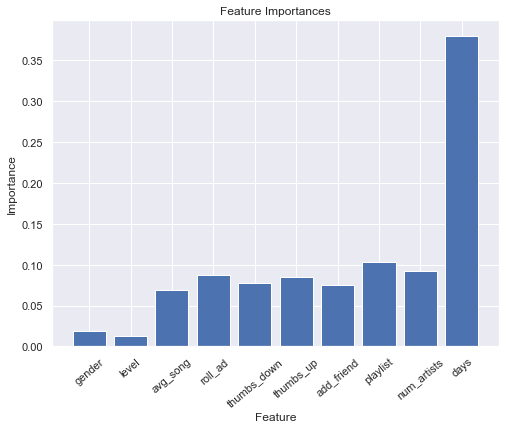

In [218]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

Here we can see that the feature with the highest importance was days since registered. Gender and level were the least important features.

# Conclusions
<a class="anchor" id="con"></a>

We started the project with a small dataset of just 128MB and 225 unique customers. After loading and cleaning our data we explored the dataset for useful features to predict churn and were able to build out the most promising features. We then preprocessed these and used the features with different machine learning algorithms. Random Forest performed the best, so we tuned the model and achieved an accuracy and F1 score of 0.88.

### Business Impact:

Now, Sparkify can use this information to target customers who are likely to churn and offer attractive incentives to stay, thereby saving Sparkify revenue and getting the customer a nice deal. Since we found that newer customers are more likely to churn, we could target them with a nice free trial of the premium service without those pesky ads! Sparkify could also work on music recommendation system so they can recommend songs that users will enjoy more and thumbs down less.

### Project Reflection

From this project I have learned how to manipulate datasets with Spark to engineer relevant features for predicting churn. I used Spark MLib to build machine learning models to predict churn. It was interesting to start with a dataset which had the customers' user interactions and then use this to predict whether or not they were likely to churn. The best model was the Random Forest classifier which achieved an accuracy and F1 score of 0.88. It was interesting to build my first model for predicting churn in pyspark as opposed to pandas. 

### Future Work

This project could have been improved by:
 - doing more feature engineering to select the best features to get a better score
 - considered overfitting problems in more depth
 - analysing mispredicted users

## References

https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition     
https://stackoverflow.com/questions/46921465/extract-substring-from-text-in-a-pandas-dataframe-as-new-column     
https://developers.whatismybrowser.com/useragents/explore/layout_engine_name/trident/     
https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/     
https://stackoverflow.com/questions/52943627/convert-a-pandas-dataframe-to-a-pyspark-dataframe     
https://stackoverflow.com/questions/29600673/how-to-delete-columns-in-pyspark-dataframe      
https://stackoverflow.com/questions/48738354/having-troubles-joining-3-dataframes-pyspark     
https://stackoverflow.com/questions/59886143/spark-dataframe-how-to-keep-only-latest-record-for-each-group-based-on-id-and    
https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame    
https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221     
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa     
https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression     
https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python    
https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python    
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html    
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html      
https://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook     
https://www.silect.is/blog/random-forest-models-in-spark-ml/     
https://stackoverflow.com/questions/75440/how-do-i-get-the-string-with-name-of-a-class